In [57]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import os

import warnings
warnings.filterwarnings("ignore")



dataset = pd.read_csv(r"C:\Users\wojci\OneDrive - SGH\School_\SGH\IRD\train.csv", low_memory= False)

In [58]:
#Drop Irrelevant Features
dataset.drop(["Name", "SSN", "ID", "Customer_ID"], axis=1, inplace=True, errors="ignore")

In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  object 
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   object 
 12  Changed_Credit_Limit      100000 non-null  object 
 13  Num_Credit_Inquiries      98035 non-null   fl

In [4]:
print("Credit Score Class Distribution")
print("Poor: ",dataset['Credit_Score'].value_counts()['Poor'])
print("Standard: ",dataset['Credit_Score'].value_counts()['Standard'])
print("Good: ",dataset['Credit_Score'].value_counts()['Good'])

Credit Score Class Distribution
Poor:  28998
Standard:  53174
Good:  17828


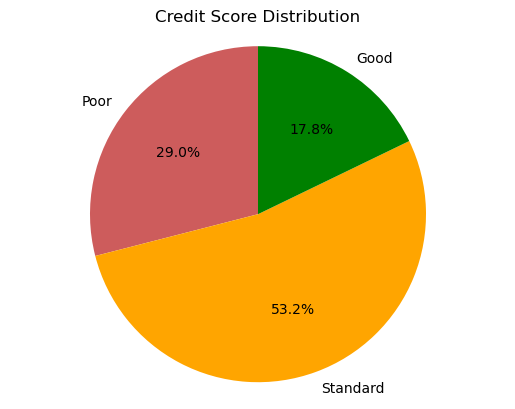

In [5]:
labels= ['Poor', 'Standard', 'Good']
colors=['indianred', 'orange', 'green']
credit = [dataset['Credit_Score'].value_counts()['Poor'],dataset['Credit_Score'].value_counts()['Standard'],dataset['Credit_Score'].value_counts()['Good']]
plt.pie(credit,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Credit Score Distribution')
plt.show()

In [6]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
print(percent_missing)

print('-' * 50)

missing_value = pd.DataFrame({
    'col_name': dataset.columns,
    'percent_missing': percent_missing
})

print(missing_value[percent_missing>0])

Month                        0.000
Age                          0.000
Occupation                   0.000
Annual_Income                0.000
Monthly_Inhand_Salary       15.002
Num_Bank_Accounts            0.000
Num_Credit_Card              0.000
Interest_Rate                0.000
Num_of_Loan                  0.000
Type_of_Loan                11.408
Delay_from_due_date          0.000
Num_of_Delayed_Payment       7.002
Changed_Credit_Limit         0.000
Num_Credit_Inquiries         1.965
Credit_Mix                   0.000
Outstanding_Debt             0.000
Credit_Utilization_Ratio     0.000
Credit_History_Age           9.030
Payment_of_Min_Amount        0.000
Total_EMI_per_month          0.000
Amount_invested_monthly      4.479
Payment_Behaviour            0.000
Monthly_Balance              1.200
Credit_Score                 0.000
dtype: float64
--------------------------------------------------
                                        col_name  percent_missing
Monthly_Inhand_Salary      M

In [7]:
dataset.isna().sum()

Month                           0
Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [8]:
try:
    dataset['Monthly_Balance'] = pd.to_numeric(dataset['Monthly_Balance'])
except ValueError as e:
    # Print the error message
    print(f"Error: {e}")

    # Identify the rows causing the error
    error_rows = dataset[pd.to_numeric(dataset['Monthly_Balance'], errors='coerce').isna()]

    # Print the rows causing the error
    print("Rows causing the error:")
    print(error_rows['Monthly_Balance'].unique())

Error: Unable to parse string "__-333333333333333333333333333__" at position 5545
Rows causing the error:
[nan '__-333333333333333333333333333__']


In [9]:
def text_to_months(text):
    if pd.isna(text):
        return 0
    # Split the text into individual words
    words = text.split()

    # Extract the years and months
    years = int(words[0])
    months = int(words[3]) if len(words) > 3 else 0

    # Calculate the total number of months
    total_months = years * 12 + months

    return total_months

dataset['Credit_History_Age'] = dataset['Credit_History_Age'].apply(text_to_months)

In [10]:
def replace_special_character(text):
        if "NM" in str(text):
            return "No"

        if "payments" in str(text) or "_" not in str(text):
            return text

        clean_text = str(text).replace("_", "")
        try:
            clean_text = pd.to_numeric(clean_text)
        except ValueError as e:
            clean_text = np.nan
        return np.nan if clean_text == "nan" or clean_text == "" else clean_text

In [11]:
dataset['Age'] = pd.to_numeric(dataset['Age'].apply(replace_special_character))
dataset['Annual_Income'] = pd.to_numeric(dataset['Annual_Income'].apply(replace_special_character))
dataset['Changed_Credit_Limit'] = pd.to_numeric(dataset['Changed_Credit_Limit'].apply(replace_special_character))
dataset['Outstanding_Debt'] = pd.to_numeric(dataset['Outstanding_Debt'].apply(replace_special_character))
dataset['Num_of_Delayed_Payment'] = pd.to_numeric(dataset['Num_of_Delayed_Payment'].apply(replace_special_character))
dataset['Amount_invested_monthly'] = pd.to_numeric(dataset['Amount_invested_monthly'].apply(replace_special_character))
dataset['Monthly_Balance'] =  pd.to_numeric(dataset['Monthly_Balance'].apply(replace_special_character))
dataset['Num_of_Loan'] =  pd.to_numeric(dataset['Num_of_Loan'].apply(replace_special_character))

In [12]:
print('Age Range: ',dataset['Age'].min(),'-',dataset['Age'].max())
print('Annual_Income Range: ',dataset['Annual_Income'].min(),'-',dataset['Annual_Income'].max())
print('Monthly_Inhand_Salary Range: ',dataset['Monthly_Inhand_Salary'].min(),'-',dataset['Monthly_Inhand_Salary'].max())
print('Num_Bank_Accounts Range: ',dataset['Num_Bank_Accounts'].min(),'-',dataset['Num_Bank_Accounts'].max())
print('Num_Credit_Card Range: ',dataset['Num_Credit_Card'].min(),'-',dataset['Num_Credit_Card'].max())
print('Interest_Rate Range: ',dataset['Interest_Rate'].min(),'-',dataset['Interest_Rate'].max())
print('Delay_from_due_date: ',dataset['Delay_from_due_date'].min(),'-',dataset['Delay_from_due_date'].max())
print('Num_of_Delayed_Payment: ',dataset['Num_of_Delayed_Payment'].min(),'-',dataset['Num_of_Delayed_Payment'].max())
print('Num_Credit_Inquiries Range: ',dataset['Num_Credit_Inquiries'].min(),'-',dataset['Num_Credit_Inquiries'].max())
print('Outstanding_Debt Range: ',dataset['Outstanding_Debt'].min(),'-',dataset['Outstanding_Debt'].max())
print('Credit_Utilization_Ratio Range: ',dataset['Credit_Utilization_Ratio'].min(),'-',dataset['Credit_Utilization_Ratio'].max())
print('Total_EMI_per_month Range: ',dataset['Total_EMI_per_month'].min(),'-',dataset['Total_EMI_per_month'].max())
print('Amount_invested_monthly Range: ',dataset['Amount_invested_monthly'].min(),'-',dataset['Amount_invested_monthly'].max())
print('Monthly_Balance Range: ',dataset['Monthly_Balance'].min(),'-',dataset['Monthly_Balance'].max())
print('Num_of_Loan Range: ',dataset['Num_of_Loan'].min(),'-',dataset['Num_of_Loan'].max())

Age Range:  -500 - 8698
Annual_Income Range:  7005.93 - 24198062.0
Monthly_Inhand_Salary Range:  303.6454166666666 - 15204.633333333331
Num_Bank_Accounts Range:  -1 - 1798
Num_Credit_Card Range:  0 - 1499
Interest_Rate Range:  1 - 5797
Delay_from_due_date:  -5 - 67
Num_of_Delayed_Payment:  -3.0 - 4397.0
Num_Credit_Inquiries Range:  0.0 - 2597.0
Outstanding_Debt Range:  0.23 - 4998.07
Credit_Utilization_Ratio Range:  20.0 - 50.00000000000001
Total_EMI_per_month Range:  0.0 - 82331.0
Amount_invested_monthly Range:  0.0 - 10000.0
Monthly_Balance Range:  0.0077596647753352 - 1602.0405189622518
Num_of_Loan Range:  -100 - 1496


In [13]:
def remove_outliers(x,f):
    try:
        # Convert to numeric
        x = pd.to_numeric(x, errors='raise')
        
        # Handle negative values
        if x < 0:
            return np.nan
        else:
            if f == 'age':
                if x>=100:
                    return np.nan
                else:
                    return x
            else:
                return x
    except ValueError:
        return np.nan

dataset['Age'] = dataset.apply(lambda x: remove_outliers(x['Age'], 'age'), axis=1)
dataset['Num_of_Delayed_Payment'] = dataset.apply(lambda x: remove_outliers(x['Num_of_Delayed_Payment'], 'none'), axis=1)
dataset['Num_of_Loan'] = dataset.apply(lambda x: remove_outliers(x['Num_of_Loan'], 'none'), axis=1)

In [14]:
dataset['Annual_Income'].fillna(dataset['Annual_Income'].median())
dataset['Changed_Credit_Limit'].fillna(dataset['Changed_Credit_Limit'].median())
dataset['Outstanding_Debt'].fillna(dataset['Outstanding_Debt'].median())
dataset['Monthly_Inhand_Salary'].fillna(dataset['Monthly_Inhand_Salary'].median())
dataset['Num_of_Delayed_Payment'].fillna(dataset['Num_of_Delayed_Payment'].median())
dataset['Num_Credit_Inquiries'].fillna(dataset['Num_Credit_Inquiries'].median())
dataset['Amount_invested_monthly'].fillna(dataset['Amount_invested_monthly'].median())
dataset['Monthly_Balance'].fillna(dataset['Monthly_Balance'].median())
dataset = dataset.dropna(subset=['Num_of_Loan'])

In [15]:
dataset['Type_of_Loan'].unique()

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       ..., 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan',
       'Payday Loan, Student Loan, Mortgage Loan, and Not Specified',
       'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan'],
      dtype=object)

In [16]:
Type_of_Loan=dataset['Type_of_Loan'].str.split(',\s*and\s*|\s*,\s*')
Type_of_Loan = Type_of_Loan.explode()
Type_of_Loan.unique()

array(['Auto Loan', 'Credit-Builder Loan', 'Personal Loan',
       'Home Equity Loan', 'Not Specified', nan, 'Mortgage Loan',
       'Student Loan', 'Debt Consolidation Loan', 'Payday Loan'],
      dtype=object)

In [17]:
dataset[(dataset['Type_of_Loan'].isnull()) & (dataset['Num_of_Loan'] != 0)]

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
5869,June,36.0,Manager,22250.525,1945.210417,4,4,7,501.0,NaN,...,Good,1443.78,33.817353,364,NM,0.0,158.193620,Low_spent_Large_value_payments,306.327421,Poor
10906,March,44.0,Architect,28840.470,2466.372500,7,7,15,1035.0,NaN,...,Standard,196.82,25.686061,358,Yes,0.0,160.476451,Low_spent_Large_value_payments,356.160799,Standard
10945,February,19.0,Entrepreneur,20785.005,1837.083750,4,5,4,1347.0,NaN,...,Good,125.84,35.350753,212,No,0.0,33.037999,High_spent_Large_value_payments,390.670376,Good
11581,June,25.0,Architect,66681.800,5278.816667,2,1,11,193.0,NaN,...,Good,679.20,27.170708,309,No,0.0,10000.000000,High_spent_Medium_value_payments,608.957382,Good
11946,March,34.0,Lawyer,30132.240,2782.020000,7,3,10,1451.0,NaN,...,Standard,162.58,34.126821,90,NM,0.0,129.218647,!@9#%8,418.983353,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96433,February,44.0,Architect,171613.600,14154.133333,5,3,5,215.0,NaN,...,Good,753.93,29.762866,335,No,0.0,1459.171505,Low_spent_Medium_value_payments,236.241829,Good
97783,August,51.0,_______,19081.510,1336.125833,8,7,9,1478.0,NaN,...,Standard,1041.07,34.085308,382,Yes,0.0,NaN,Low_spent_Large_value_payments,327.730272,Standard
97855,August,36.0,Writer,17222.530,1697.210833,8,4,18,83.0,NaN,...,Standard,1163.47,26.902948,347,Yes,24276.0,65.706733,High_spent_Small_value_payments,364.014351,Standard
99295,August,20.0,Mechanic,32700.000,2802.000000,2,4,5,18.0,NaN,...,Good,1440.50,25.164870,204,No,0.0,230.508250,!@9#%8,319.691750,Good


In [18]:
dataset = dataset.dropna(subset=['Type_of_Loan'])

In [19]:
Type_of_Loan=dataset['Type_of_Loan'].str.split(',\s*and\s*|\s*,\s*')
Type_of_Loan = Type_of_Loan.explode()
loan_type_label = Type_of_Loan.unique()

In [20]:
def replace_and(text):
        clean_text = str(text).replace(" and", "")
        return np.nan if clean_text == "nan" else clean_text

In [21]:
dataset['Type_of_Loan'] = dataset['Type_of_Loan'].apply(replace_and)
for loan_type in loan_type_label:
    dataset['Count_' + loan_type] = dataset['Type_of_Loan'].apply(lambda x: x.split(', ').count(loan_type))

In [22]:
sum_of_encoded = dataset[['Count_Auto Loan', 'Count_Credit-Builder Loan', 'Count_Personal Loan', 'Count_Home Equity Loan', 'Count_Not Specified', 'Count_Mortgage Loan','Count_Student Loan', 'Count_Debt Consolidation Loan', 'Count_Payday Loan']].sum(axis=1)

In [23]:
dataset['sum_equals_num_loan'] = sum_of_encoded == dataset['Num_of_Loan']
dataset[dataset['sum_equals_num_loan'] == False]

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Count_Auto Loan,Count_Credit-Builder Loan,Count_Personal Loan,Count_Home Equity Loan,Count_Not Specified,Count_Mortgage Loan,Count_Student Loan,Count_Debt Consolidation Loan,Count_Payday Loan,sum_equals_num_loan
21,June,34.0,Engineer,143162.640,12187.220000,1,5,8,967.0,"Auto Loan, Auto Loan, Not Specified",...,2,0,0,0,1,0,0,0,0,False
810,March,26.0,Writer,134321.440,11064.453333,3,5,12,1464.0,"Student Loan, Student Loan, Debt Consolidation...",...,0,0,0,0,0,1,2,1,0,False
1390,July,21.0,Lawyer,124419.660,10221.305000,3,4,11,622.0,"Home Equity Loan, Home Equity Loan, Payday Loa...",...,0,0,0,2,0,1,0,0,1,False
2008,January,21.0,Accountant,31069.320,2361.110000,2,3,12,352.0,"Auto Loan, Student Loan",...,1,0,0,0,0,0,1,0,0,False
2273,February,NaN,_______,38539.570,3438.630833,4,2,3,472.0,Mortgage Loan,...,0,0,0,0,0,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99760,January,35.0,_______,17818.600,1659.883333,4,6,14,661.0,Not Specified,...,0,0,0,0,1,0,0,0,0,False
99769,February,23.0,Architect,60015.320,5121.276667,7,679,14,978.0,"Mortgage Loan, Mortgage Loan, Credit-Builder L...",...,0,1,1,0,1,3,0,0,1,False
99845,June,23.0,Architect,11834.645,688.220417,5,7,10,216.0,"Credit-Builder Loan, Payday Loan",...,0,1,0,0,0,0,0,0,1,False
99853,June,40.0,Scientist,81093.160,7017.763333,10,7,17,349.0,"Auto Loan, Payday Loan, Auto Loan, Student Loa...",...,2,0,0,1,0,0,3,0,1,False


In [24]:
print('When Num_of_Loan does not equal to the count in Type_of_Loan')
print('Num_of_Loan Range: ',dataset.loc[dataset['sum_equals_num_loan'] == False, 'Num_of_Loan'].min(),'-',dataset.loc[dataset['sum_equals_num_loan'] == False, 'Num_of_Loan'].max())
print('Num_of_Loan Median: ',dataset.loc[dataset['sum_equals_num_loan'] == False, 'Num_of_Loan'].median())

When Num_of_Loan does not equal to the count in Type_of_Loan
Num_of_Loan Range:  17.0 - 1496.0
Num_of_Loan Median:  752.0


Based on the checking done above, we decided to remove the Num_of_Loan field. We also removed the sum_equals_num_loan field since it is not needed anymore.

In [25]:
dataset.drop(['Num_of_Loan', 'sum_equals_num_loan'], axis=1, inplace=True, errors="ignore")

In [26]:
#Checking the value in count type of loan
dataset.loc[dataset['Type_of_Loan'] == 'Auto Loan, Auto Loan']

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Type_of_Loan,Delay_from_due_date,...,Credit_Score,Count_Auto Loan,Count_Credit-Builder Loan,Count_Personal Loan,Count_Home Equity Loan,Count_Not Specified,Count_Mortgage Loan,Count_Student Loan,Count_Debt Consolidation Loan,Count_Payday Loan
912,January,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
913,February,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
914,March,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
915,April,39.0,_______,30536.62,NaN,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
916,May,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Poor,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89874,March,26.0,Scientist,53878.98,4328.915000,4,3,5,"Auto Loan, Auto Loan",11,...,Good,2,0,0,0,0,0,0,0,0
89875,April,26.0,Scientist,53878.98,NaN,4,3,5,"Auto Loan, Auto Loan",11,...,Standard,2,0,0,0,0,0,0,0,0
89876,May,26.0,Scientist,53878.98,4328.915000,4,3,5,"Auto Loan, Auto Loan",11,...,Standard,2,0,0,0,0,0,0,0,0
89877,June,26.0,_______,53878.98,4328.915000,4,3,5,"Auto Loan, Auto Loan",11,...,Standard,2,0,0,0,0,0,0,0,0


In [27]:
dataset.drop(["Type_of_Loan"], axis=1, inplace=True, errors="ignore")

In [28]:
dataset.dropna(inplace=True)
dataset["Age"] = pd.to_numeric(dataset["Age"])
dataset["Annual_Income"] = pd.to_numeric(dataset["Annual_Income"])
dataset["Num_of_Delayed_Payment"] = pd.to_numeric(dataset["Num_of_Delayed_Payment"])
dataset["Changed_Credit_Limit"] = pd.to_numeric(dataset["Changed_Credit_Limit"])
dataset["Outstanding_Debt"] = pd.to_numeric(dataset["Outstanding_Debt"])
dataset["Amount_invested_monthly"] = pd.to_numeric(dataset["Amount_invested_monthly"])
dataset["Monthly_Balance"] = pd.to_numeric(dataset["Monthly_Balance"])

In [29]:
dataset.drop(dataset[dataset['Occupation'] == '_______'].index, inplace = True)
dataset.drop(dataset[dataset['Credit_Mix'] == '_'].index, inplace = True)
dataset.drop(dataset[dataset['Payment_of_Min_Amount'] == 'NM'].index, inplace = True)
dataset.drop(dataset[dataset['Payment_Behaviour'] == '!@9#%8'].index, inplace = True)

In [30]:
print('Number of Rows with Missing Values: ', dataset.isnull().any(axis=1).sum())
print('Number of Rows: ', dataset.any(axis=1).sum())

Number of Rows with Missing Values:  0
Number of Rows:  35688


In [31]:
print("Credit Score Class Distribution")
print("Poor: ",dataset['Credit_Score'].value_counts()['Poor'])
print("Standard: ",dataset['Credit_Score'].value_counts()['Standard'])
print("Good: ",dataset['Credit_Score'].value_counts()['Good'])

Credit Score Class Distribution
Poor:  11139
Standard:  18956
Good:  5593


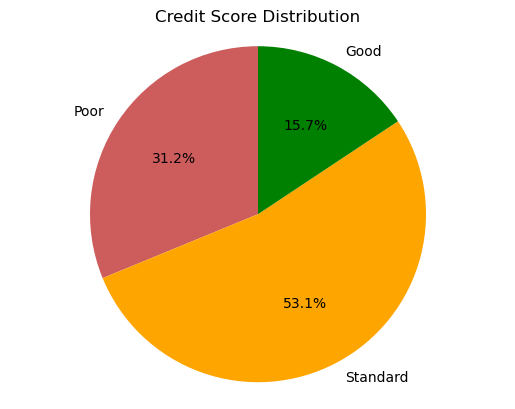

In [32]:
labels= ['Poor', 'Standard', 'Good']
colors=['indianred', 'orange', 'green']
credit = [dataset['Credit_Score'].value_counts()['Poor'],dataset['Credit_Score'].value_counts()['Standard'],dataset['Credit_Score'].value_counts()['Good']]
plt.pie(credit,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Credit Score Distribution')
plt.show()

Based on the target variable's distribution above, we also need to solve this imbalanced data.

In [33]:
for column in dataset.select_dtypes(include='object').columns:
    print(column)
    print(dataset[column].unique())
    print('\n')

Month
['July' 'August' 'February' 'May' 'June' 'January' 'April' 'March']


Occupation
['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Lawyer' 'Doctor'
 'Journalist' 'Manager' 'Media_Manager' 'Mechanic' 'Accountant'
 'Architect' 'Musician' 'Writer' 'Developer']


Credit_Mix
['Good' 'Standard' 'Bad']


Payment_of_Min_Amount
['No' 'Yes']


Payment_Behaviour
['Low_spent_Small_value_payments' 'High_spent_Medium_value_payments'
 'High_spent_Large_value_payments' 'High_spent_Small_value_payments'
 'Low_spent_Large_value_payments' 'Low_spent_Medium_value_payments']


Credit_Score
['Good' 'Standard' 'Poor']




As for Payment_Behaviour we decide to split this into two columns, containing the 'spent' and 'value' payment level.

In [34]:
dataset['Spent Amount Payment_Behaviour'] = dataset['Payment_Behaviour'].str.extract(r'(\w+)_spent')
dataset['Value Amount Payment_Behaviour'] = dataset['Payment_Behaviour'].str.extract(r'_spent_(\w+)_value')

In [35]:
dataset.drop(["Payment_Behaviour"], axis=1, inplace=True, errors="ignore")

In [36]:
dataset['Spent Amount Payment_Behaviour'].unique()


array(['Low', 'High'], dtype=object)

In [37]:
dataset['Value Amount Payment_Behaviour'].unique()


array(['Small', 'Medium', 'Large'], dtype=object)

In [38]:
spent_mapping = {'Low': 0, 'High': 1}
value_mapping = {'Small': 0, 'Medium': 1, 'Large': 2}
month_mapping = {'January': 1,'February': 2,'March': 3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12}

# Encode the categories to integers
dataset['Spent Amount Payment_Behaviour'] = dataset['Spent Amount Payment_Behaviour'].map(spent_mapping)
dataset['Value Amount Payment_Behaviour'] = dataset['Value Amount Payment_Behaviour'].map(value_mapping)
dataset['Month'] = dataset['Month'].map(month_mapping)

Next we will also encode the target variable for the model.

In [39]:
X = dataset.loc[:, dataset.columns != "Credit_Score"]
y = dataset["Credit_Score"]

In [40]:
print("Credit Score Class Distribution")
print("Poor: ",y.value_counts()[0])
print("Standard: ",y.value_counts()[1])
print("Good: ",y.value_counts()[2])

Credit Score Class Distribution
Poor:  18956
Standard:  11139
Good:  5593


# Solving Imbalanced Data
Here we will try to handle the imbalanced data using Random Undersampler. We chose random undersampler since the dataset is pretty large and we want to reduce the training time of our models, such that we can focus on the impact of hyperparameter tuning.

For RF models usually the best oversampling technique is RandomOverSampling

In [41]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("Original class distribution:", Counter(y))

# Oversample the dataset
oversampler = RandomOverSampler(random_state=0)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Print the class distribution after resampling
print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({'Standard': 18956, 'Poor': 11139, 'Good': 5593})
Resampled class distribution: Counter({'Good': 18956, 'Standard': 18956, 'Poor': 18956})


In [42]:
print("Credit Score Class Distribution")
print("Poor: ",y_resampled.value_counts()[0])
print("Standard: ",y_resampled.value_counts()[1])
print("Good: ",y_resampled.value_counts()[2])

Credit Score Class Distribution
Poor:  18956
Standard:  18956
Good:  18956


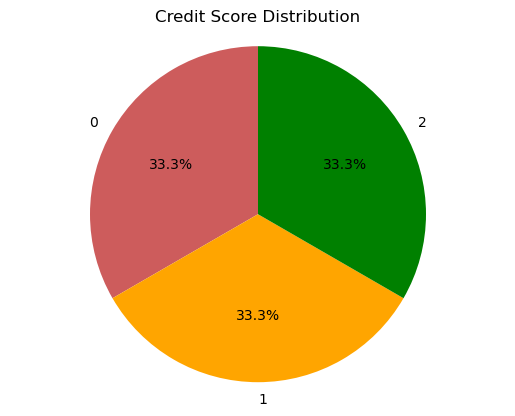

In [43]:
labels= [0, 1, 2]
colors=['indianred', 'orange', 'green']
credit = [y_resampled.value_counts()[0],y_resampled.value_counts()[1],y_resampled.value_counts()[2]]
plt.pie(credit,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Credit Score Distribution')
plt.show()

In [44]:
X_resampled['Credit_Score'] = y_resampled

In [45]:
X_resampled

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_of_Delayed_Payment,...,Count_Personal Loan,Count_Home Equity Loan,Count_Not Specified,Count_Mortgage Loan,Count_Student Loan,Count_Debt Consolidation Loan,Count_Payday Loan,Spent Amount Payment_Behaviour,Value Amount Payment_Behaviour,Credit_Score
0,7,23.0,Scientist,19114.120,1824.843333,3,4,3,3,8.0,...,1,1,0,0,0,0,0,0,0,Good
1,8,23.0,Scientist,19114.120,1824.843333,3,4,3,3,6.0,...,1,1,0,0,0,0,0,1,1,Standard
2,2,28.0,Teacher,34847.840,3037.986667,2,4,6,7,1.0,...,0,0,0,0,0,0,0,1,2,Good
3,5,28.0,Teacher,34847.840,3037.986667,2,4,6,3,1.0,...,0,0,0,0,0,0,0,0,0,Good
4,6,28.0,Teacher,34847.840,3037.986667,2,4,6,3,0.0,...,0,0,0,0,0,0,0,1,2,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56863,4,43.0,Journalist,8875.135,989.594583,8,9,27,26,14.0,...,0,0,0,0,0,0,1,0,0,Poor
56864,4,42.0,Doctor,30243.640,2743.303333,10,7,23,19,15.0,...,0,1,0,1,1,0,2,0,2,Poor
56865,1,30.0,Architect,37442.050,3081.170833,0,5,11,11,7.0,...,0,0,0,1,1,0,0,0,2,Poor
56866,2,38.0,Writer,10030.520,696.876667,10,9,27,47,19.0,...,1,0,2,0,2,0,2,0,1,Poor


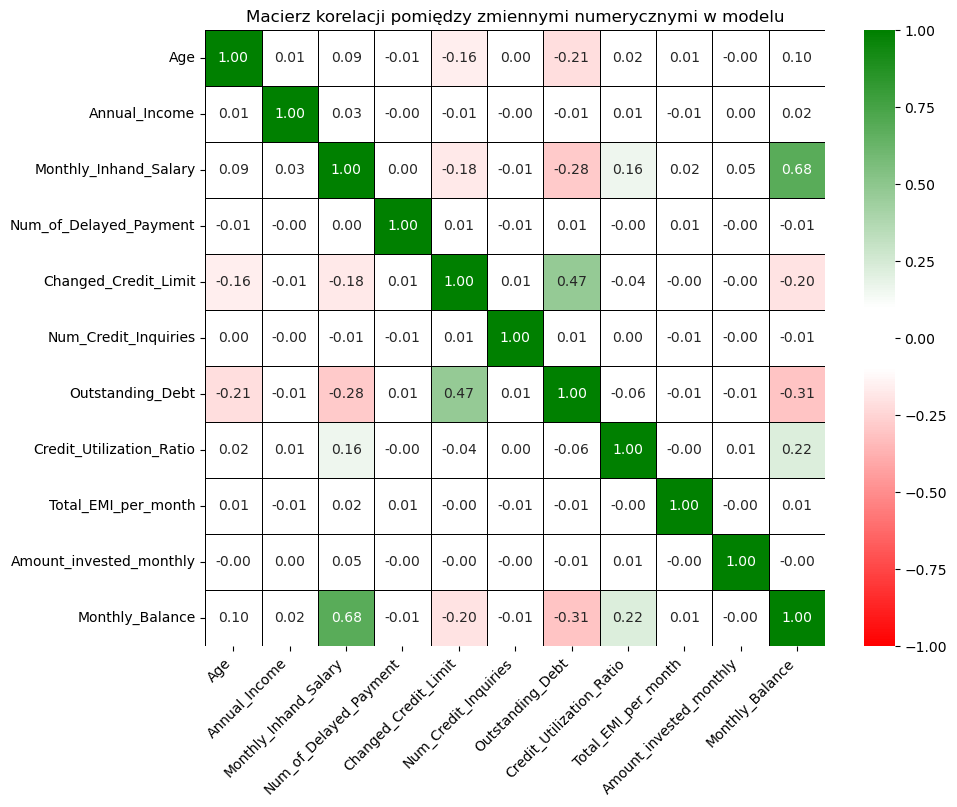

In [54]:
from matplotlib.colors import LinearSegmentedColormap


# Filter the DataFrame to include only float or string columns
filtered_df = X_resampled.select_dtypes(include=['float64', 'object'])

# Create the correlation matrix for float columns only, since correlation is not defined for strings
correlation_matrix = filtered_df.select_dtypes(include=['float64']).corr()
colors = [(0, 'red'), (0.45, 'white'), (0.55, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1, center=0, fmt=".2f", 
            linecolor='black', linewidths=0.5)
plt.title('Macierz korelacji pomiędzy zmiennymi numerycznymi w modelu')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees to the left
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal
plt.show()


In [46]:
#X_resampled.to_csv(r"C:\Users\wojci\OneDrive - SGH\School_\SGH\IRD\preprocessed_V2.2_oversampling.csv")